# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [ ]:
!git clone https://github.com/MadaneA/MACS3-Statistiques-Descriptives-TDs.git

In [1]:
import os
os.getcwd()

'/home/davidson/Documents/ING_MACS/MACS3_M2/courses/macs/Stat_descriptives/TD_stats/TD3'

In [2]:
import os
os.chdir('/home/davidson/Documents/ING_MACS/MACS3_M2/courses/macs/Stat_descriptives/TD_stats')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_accars = pd.read_excel('./data/accars_b.xlsx')

In [22]:
data_accars.head()

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
0,CLIMB,186,10,192,1,Neutral,1.0,151.0,6.0,-0.1146,...,88.0,0.57,0.73,0.12,0.13,8.9,5.0,5.0,5335.0,0.637
1,CLIMB,186,10,192,1,Neutral,1.0,143.0,7.0,-0.2464,...,90.8,0.58,0.76,0.15,0.10,9.0,5.6,5.6,4987.0,0.624
2,CLIMB,186,10,192,1,Neutral,1.0,163.0,8.0,NaN,...,89.0,0.28,0.48,0.16,0.05,10.1,5.0,5.2,4251.0,0.530
3,CLIMB,186,10,192,1,Neutral,1.0,152.0,9.0,NaN,...,87.0,0.44,0.67,0.14,0.08,8.9,5.6,5.6,5356.0,0.380
4,CLIMB,186,10,192,1,Neutral,1.0,154.0,10.0,NaN,...,85.3,0.26,0.48,0.25,0.06,10.5,5.6,5.6,NaN,0.543


#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

Oui, il a des valeurs manquantes

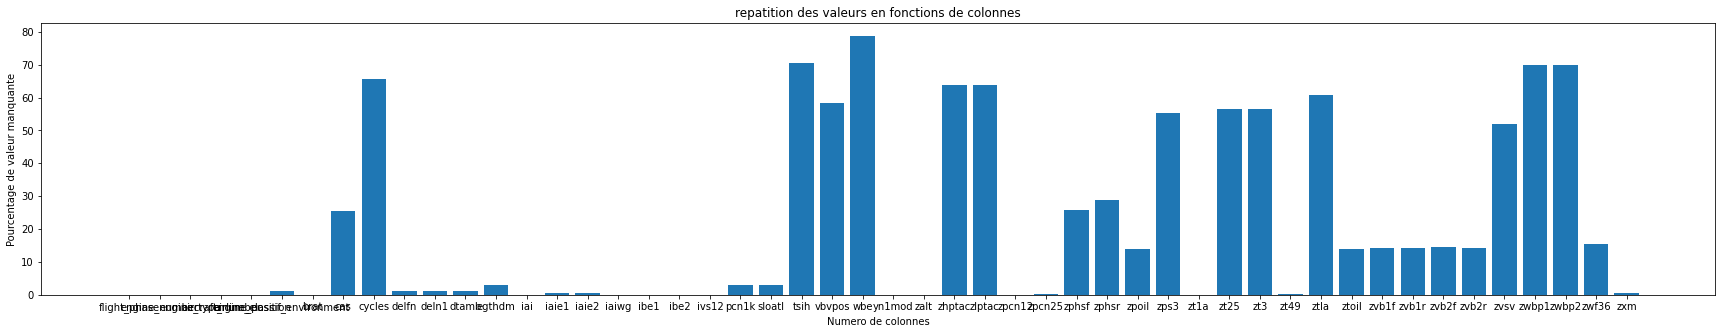

In [28]:
isna_accars = data_accars.isna()
nb_insa_col = ((np.array(isna_accars.sum()))/data_accars.shape[0])*100
plt.figure(figsize=(30,5))
plt.bar(x = data_accars.columns, height = nb_insa_col)
plt.title("repatition des valeurs en fonctions de colonnes")
plt.xlabel("Numero de colonnes")
plt.ylabel("Pourcentage de valeur manquante")
plt.show()

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [36]:
data_accars_clc = data_accars[isna_accars["cycles"].isin([False])]
isna_accars_clc = data_accars_clc.isna()
data_accars_clean = data_accars_clc[isna_accars_clc["egthdm"].isin([False])]

In [42]:
print("le nombre de valeurs manquantes dans la colonne cycles : {}".format(data_accars_clean.isna().sum()["cycles"]))
print("le nombre de valeurs manquantes dans la colonne egthdm : {}".format(data_accars_clean.isna().sum()["egthdm"]))

le nombre de valeurs manquantes dans la colonne cycles : 0
le nombre de valeurs manquantes dans la colonne egthdm : 0


#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [43]:
print("Les types de moteurs : {}".format(np.unique(data_accars_clean['engine_type'])))

Les types de moteurs : [ 5  7 10]


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [46]:
by_egn_type = data_accars_clean[data_accars_clean["engine_type"].isin([10])] 
by_egn_type.head()

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
104,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,5.0,23.8191,...,84.3,0.39,0.58,0.05,0.15,12.3,0.2,0.0,NaN,0.133
105,TAKEOFF,186,10,192,1,Neutral,0.0,93.0,6.0,25.4038,...,95.1,0.24,0.69,0.16,0.10,11.1,0.2,0.0,NaN,0.148
106,TAKEOFF,186,10,192,1,Neutral,0.0,92.0,7.0,22.7509,...,81.6,0.23,0.46,0.13,0.11,12.1,0.3,0.0,NaN,0.140
107,TAKEOFF,186,10,192,1,Neutral,0.0,87.0,8.0,22.1533,...,87.8,0.59,0.80,0.12,0.13,11.1,0.2,0.0,NaN,0.140
108,TAKEOFF,186,10,192,1,Neutral,0.0,88.0,9.0,23.8673,...,79.3,0.43,0.47,0.13,0.17,12.5,0.3,0.0,NaN,0.136


In [48]:
by_egn_type.shape

(712, 50)

In [54]:
print("le nombre de moteur sur un avion est : {}".format(len(np.unique(by_egn_type["engine_position"]))))
print("le nombre d'avion distinct est : {}".format(len(np.unique(by_egn_type["aircraft_number"]))))

le nombre de moteur sur un avion est : 2
le nombre d'avion distinct est : 5


In [57]:
print("le nombre d'avion distinct est : {}".format(np.unique(by_egn_type["aircraft_number"])))

le nombre d'avion distinct est : [ 11  14 190 191 192]


In [56]:
print(np.unique(by_egn_type["flight_phase"]))

['TAKEOFF']


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [63]:
row_ = data_accars_clean[data_accars_clean["aircraft_number"].isin([190])].loc[:, ["engine_number","cycles", "egthdm"]]
print(row_)

       engine_number  cycles   egthdm
11398            179    98.0  52.0118
11399            180    69.0  57.6415
11400            180    75.0  48.7217
11755            179     0.0  37.6572
11756            179     1.0  37.2208
...              ...     ...      ...
45809            180    48.0  51.9444
45810            180    58.0  59.0032
46111            179   163.0  45.8711
46411            179    30.0  56.5585
46412            179   101.0  41.0874

[220 rows x 3 columns]


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

In [67]:
engines_num = np.unique(row_["engine_number"])
egn1 = row_[row_["engine_number"].isin([engines_num[0]])]
egn2 = row_[row_["engine_number"].isin([engines_num[1]])]

[Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'Evolution de la marge EGT au cours du temps pour le moteur 179')]

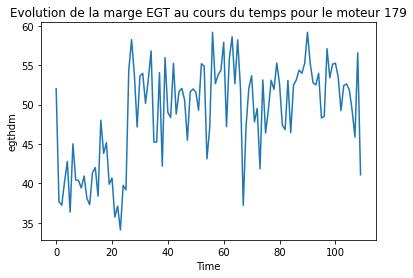

In [77]:
sns.lineplot(data = egn1, x = range(len(egn1)), y = "egthdm").set( xlabel = "Time", title = "Evolution de la marge EGT au cours du temps pour le moteur {}".format(engines_num[0]))

[Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'Evolution de la marge EGT au cours du temps pour le moteur 180')]

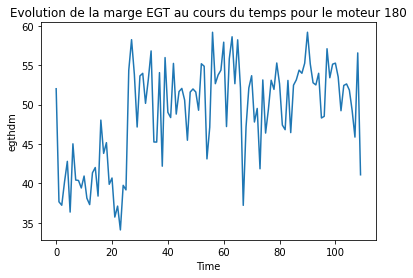

In [78]:
sns.lineplot(data = egn1, x = range(len(egn2)), y = "egthdm").set( xlabel = "Time", title = "Evolution de la marge EGT au cours du temps pour le moteur {}".format(engines_num[1]))

#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [80]:
isna_egn1 = egn1.isna()
isna_egn1.sum()

engine_number    0
cycles           0
egthdm           0
dtype: int64

#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [ ]:
from sklearn.linear_model import LinearRegression

### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?